# Fix $\Omega_m = 1$

How would a model without dark energy (i.e. $\Omega_m = 1$) perform? Do these data contain evidence of dark energy? (Hint: this is a model selection problem!)

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import sys
path = r"C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\venv\Utilities"
sys.path.append(path)
import plot_settings

In [2]:
data = np.genfromtxt(r'C:\Users\ricca\Documents\Unimib-Code\Astrostatistics\Notebooks\Data\mu_z.txt', delimiter=' ')

In [3]:
z_sample  = data[:, 0]
mu_sample = data[:, 1]
dmu       = data[:, 2]

<>:3: SyntaxWarning: invalid escape sequence '\m'
<>:3: SyntaxWarning: invalid escape sequence '\m'
C:\Users\ricca\AppData\Local\Temp\ipykernel_17692\2962798895.py:3: SyntaxWarning: invalid escape sequence '\m'
  plt.ylabel("$\mu$")


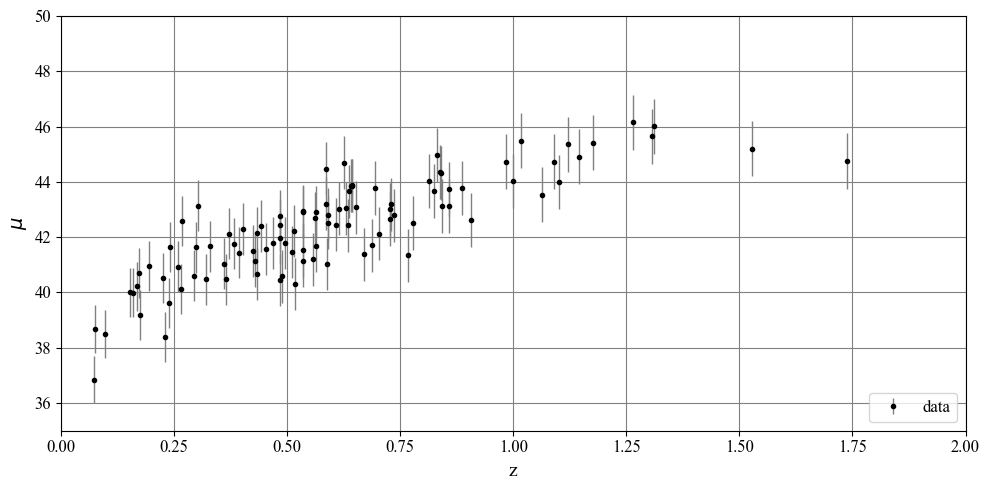

In [4]:
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1,label='data')
plt.xlabel("z")
plt.ylabel("$\mu$")
plt.legend(loc='lower right')
plt.xlim(0,2)
plt.ylim(35,50);

# MCMC

In [6]:
from scipy.integrate import quad

c = 299792.458  # velocità della luce in km/s

def integrand(zp):
    return 1.0 / np.sqrt(zp**3 + 1)

def mu_theoretical(z, H0):
    mu = []
    for zi in z:
        integral, _ = quad(integrand, 0, zi)
        dL = (c / H0) * (1 + zi) * integral  # luminosity distance in Mpc
        mu_i = 5 * np.log10(dL * 1e6 / 10)   # convert Mpc to pc and apply modulus formula
        mu.append(mu_i)
    return np.array(mu)


In [8]:
def log_likelihood(theta):
    H0 = theta
    if H0 <= 0:
        return -np.inf
    mu_model = mu_theoretical(z_sample, H0)
    return -0.5 * np.sum(((mu_sample - mu_model) / dmu)**2 + np.log(2 * np.pi * dmu**2))

In [16]:
def log_prior(theta):
    H0 = theta
    if 50 < H0 < 100:
        return 0.0
    return -np.inf

In [17]:
def log_posterior(theta):
    lp = log_prior(theta)
    if not np.isfinite(lp):
        return -np.inf
    return lp + log_likelihood(theta)

In [18]:
ndim = 1
nwalkers = 10
nsteps = 1000

In [19]:
initial = np.array([70])  # H0, Omega_m
p0 = initial + 1e-2 * np.random.randn(nwalkers, ndim)

In [20]:
import emcee

In [21]:
sampler = emcee.EnsembleSampler(nwalkers, ndim, log_posterior)

In [22]:
sampler.run_mcmc(p0, nsteps, progress=True)

100%|██████████| 1000/1000 [01:42<00:00,  9.76it/s]


State([[82.74601506]
 [82.29223537]
 [82.8035587 ]
 [82.00384462]
 [82.21425756]
 [81.8784188 ]
 [82.44111208]
 [82.31863247]
 [82.21718304]
 [82.19187066]], log_prob=[-42346.8162092  -42345.57388786 -42347.0867768  -42345.61459353
 -42345.52083777 -42345.83576294 -42345.80632667 -42345.60256179
 -42345.52197307 -42345.5143593 ], blobs=None, random_state=('MT19937', array([4039255257, 2914796520, 1497130486, 1010888641,  164490504,
        889606036, 3398328357, 2627661662,  408642457, 3260505225,
       3303572341, 3011070314, 1990636951, 3070191375,  512608262,
       4075676173, 3648913584,  801290896,  262883136,  744775564,
       4061398534, 3572790739, 3805091776, 2137975790, 1294555251,
       2258369917, 1441970396, 1788216448,  653771485, 3300520271,
        163172530, 3062020039, 1074562031, 2810123111, 2189257416,
        197077320, 2928518493, 2412376610,  953842513, 3369519749,
       3027089475, 3889827681, 2203299064, 3389114663, 1061824944,
       1338915888, 290184823

In [33]:
flat_samples = sampler.get_chain(discard=100, thin=10, flat=True)

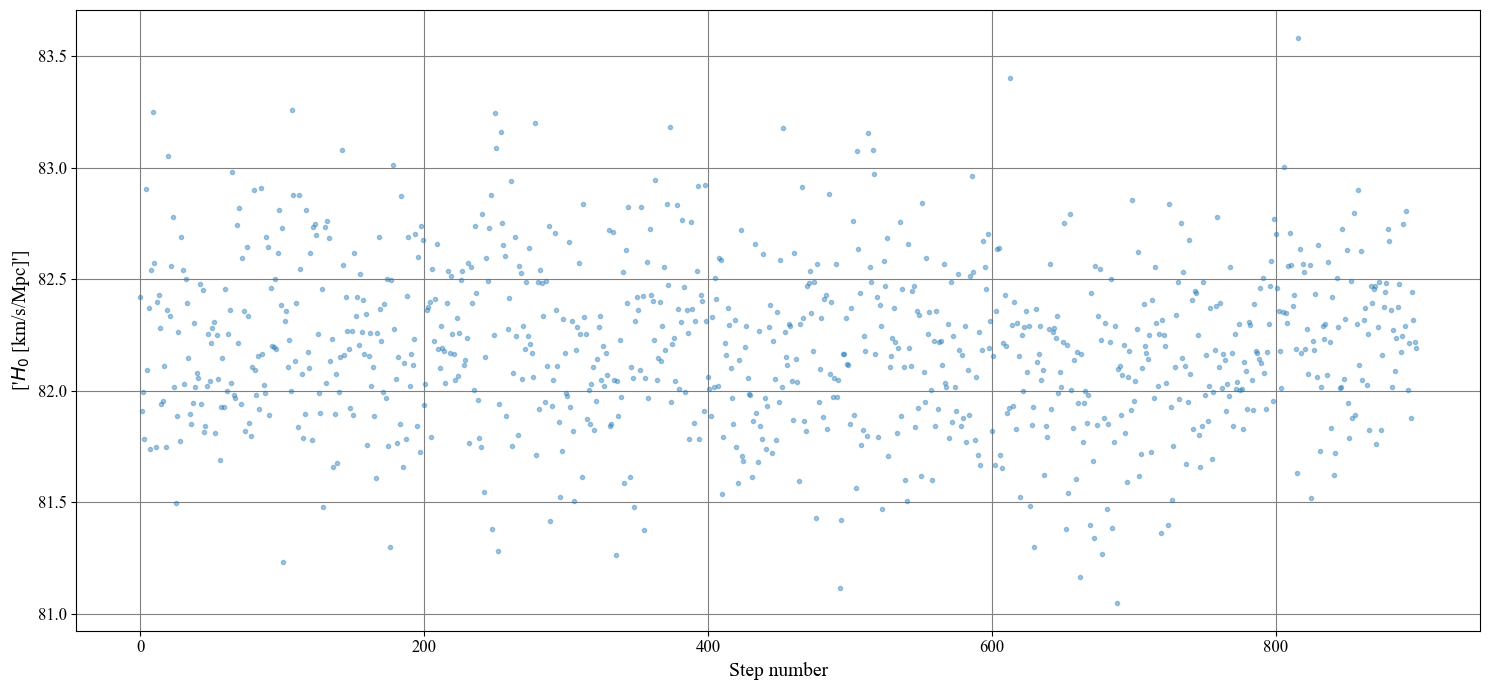

In [34]:
fig, axes = plt.subplots(ndim, figsize=(15, 7), sharex=True)
labels = [r"$H_0$ [km/s/Mpc]"]

# Assuming sampler.get_chain() shape is (n_steps, n_walkers, ndim)
chain = flat_samples

ax = axes
# Plot every 8th walker
for walker in range(0, chain.shape[1], 8):
    ax.plot(chain[:, walker], '.', alpha=0.4)
ax.set_ylabel(labels)
ax.grid(True)

axes.set_xlabel("Step number")
plt.tight_layout()


In [35]:
import corner

<>:20: SyntaxWarning: invalid escape sequence '\O'
<>:20: SyntaxWarning: invalid escape sequence '\O'
C:\Users\ricca\AppData\Local\Temp\ipykernel_17692\1202911014.py:20: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)
C:\Users\ricca\AppData\Local\Temp\ipykernel_17692\1202911014.py:20: SyntaxWarning: invalid escape sequence '\O'
  fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)


TypeError: 'Axes' object is not subscriptable

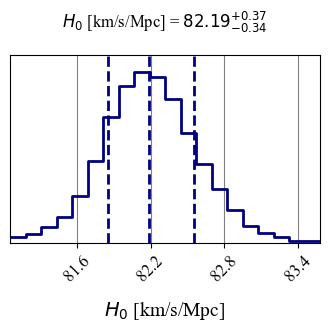

In [36]:
fig = corner.corner(
    flat_samples,
    labels=[r"$H_0$ [km/s/Mpc]", r"$\Omega_m$"],
    truths=[70],  # Optional: if you want to show true/expected values
    show_titles=True,
    title_fmt=".2f",
    title_kwargs={"fontsize": 12},
    label_kwargs={"fontsize": 14},
    quantiles=[0.16, 0.5, 0.84],
    levels=(0.68, 0.95),
    plot_contours=True,
    plot_density=True,
    plot_datapoints=False,  # cleaner look
    color="navy",
    smooth=1.0,  # smoothing for density
    smooth1d=1.0,
    figsize=(6, 6),
)

fig.suptitle("Posterior Distributions for $H_0$ and $\Omega_m$", fontsize=16)
plt.tight_layout()
plt.show()


In [37]:
import numpy as np

# Assuming `flat_samples` is of shape (n_samples, 2) → [H0, Omega_m]
param_names = ['H0']
results = []

for i in range(flat_samples.shape[1]):
    mcmc = np.percentile(flat_samples[:, i], [16, 50, 84])
    q = np.diff(mcmc)
    results.append((mcmc[1], q[0], q[1]))
    print(f"{param_names[i]} = {mcmc[1]:.2f} (+{q[1]:.2f}, -{q[0]:.2f})")


H0 = 82.19 (+0.37, -0.34)


In [38]:
# Generate smooth z values to plot the model line
z_fit = np.linspace(min(z_sample), max(z_sample), 200)  # or a range covering your data

In [39]:
mu_chain = []
for h0 in flat_samples[np.random.choice(len(flat_samples), 500, replace=False)]:
    mu_chain.append(mu_theoretical(z_fit, H0=h0))
mu_chain = np.array(mu_chain)

In [40]:
mu_median = np.median(mu_chain, axis=0)
mu_lower = np.percentile(mu_chain, 16, axis=0)
mu_upper = np.percentile(mu_chain, 84, axis=0)

In [47]:
mu_lower.T[0]

array([37.284508  , 37.53538829, 37.76333509, 37.97239767, 38.16563421,
       38.34541105, 38.51359686, 38.67169312, 38.82092444, 38.96230277,
       39.09667394, 39.22475217, 39.34714605, 39.46437837, 39.57690159,
       39.68510987, 39.78934871, 39.88992264, 39.98710146, 40.08112534,
       40.17220897, 40.26054511, 40.34630742, 40.42965295, 40.51072416,
       40.5896507 , 40.66655091, 40.74153307, 40.81469653, 40.88613268,
       40.95592577, 41.02415361, 41.09088827, 41.15619659, 41.22014069,
       41.2827784 , 41.34416366, 41.40434687, 41.46337517, 41.52129275,
       41.57814107, 41.63395909, 41.68878347, 41.74264876, 41.79558756,
       41.84763065, 41.89880716, 41.94914464, 41.99866921, 42.04740569,
       42.0953776 , 42.14260734, 42.18911623, 42.23492455, 42.28005167,
       42.32451607, 42.36833539, 42.41152652, 42.45410559, 42.49608809,
       42.53748884, 42.57832206, 42.61860141, 42.65834001, 42.69755048,
       42.73624495, 42.77443512, 42.81213224, 42.84934719, 42.88

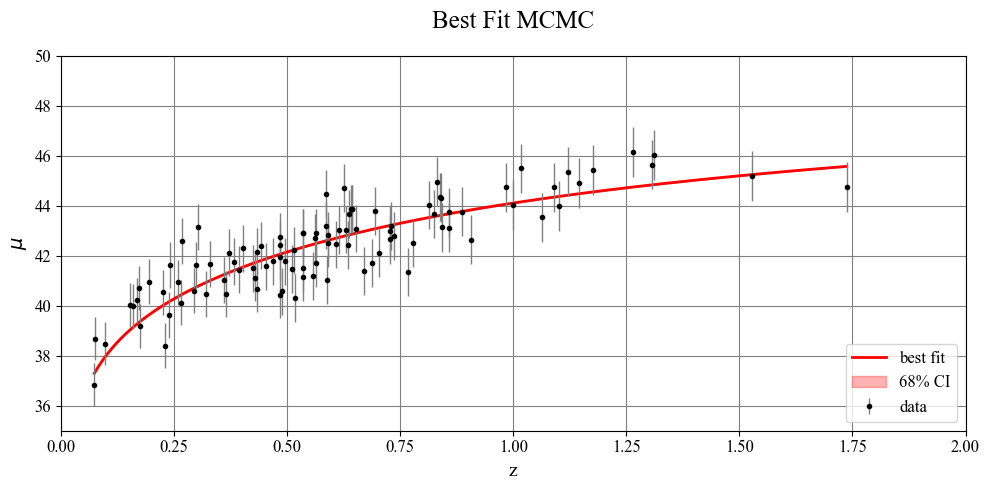

In [48]:
plt.plot(z_fit, mu_median, lw=2, color='r', label='best fit')
plt.fill_between(z_fit, mu_lower.T[0], mu_upper.T[0], color='r', alpha=0.3, label='68% CI')
plt.title('Best Fit MCMC')
plt.errorbar(z_sample, mu_sample, dmu, fmt='.k', ecolor='gray', lw=1, label='data')
plt.xlabel("z")
plt.ylabel(r"$\mu$")
plt.legend(loc='lower right')
plt.xlim(0, 2)
plt.ylim(35, 50)
plt.grid(True)


In [51]:
with open('omega_m_is_one.txt', 'w') as f:
    for z,mum, mul, mup in zip(z_fit, mu_median, mu_lower, mu_upper):
        f.write(f'{z}\t{mul[0]}\t{mum[0]}\t{mup[0]}\n')